<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn_lvq import GlvqModel
from sklearn_lvq.utils import plot2d

In [146]:
df    = pd.read_csv('cluster.csv')
X = df[['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11']].to_numpy()
X = df[['x1','x2']].to_numpy()

#Normalizing the data
#sc = StandardScaler()
#X = sc.fit_transform(X)
#y = sc.fit_transform(Y)

## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test = train_test_split(X, test_size=0.7, random_state=5)

# **K-means**


In [147]:
for c in [2,3,4,5,10,20,25,29]:
  k_means = KMeans(init='k-means++', n_clusters=c, n_init=10) # otro es MiniBatchKMeans
  t0 = time.time()
  k_means = k_means.fit(X_train)
  t_batch = time.time() - t0

  #k_means.predict([[4,8,20,40,74,80,77,40,22,8,3], [4,8,20,40,74,80,77,40,22,8,3]])
  y_pred = k_means.predict(X_test)

  values = k_means.cluster_centers_.squeeze()
  labels = k_means.labels_
  #print("Centroides", k_means.cluster_centers_)
  print(labels)
  print('Exactitud:', k_means.score(X_test))

[1 0 1 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1 0 1 0 1 1]
Exactitud: -443.5650352487056
[2 0 1 0 1 0 0 0 1 0 2 1 1 0 1 1 2 0 1 0 1 0 0 2 0 2 0 2 1]
Exactitud: -161.95585946745558
[1 0 2 0 2 3 0 0 2 3 1 2 2 3 2 2 1 0 2 0 2 3 3 1 0 1 0 1 2]
Exactitud: -51.985749999999996
[2 0 1 0 1 3 0 0 1 3 2 4 4 3 4 1 2 0 1 0 4 3 3 2 0 2 0 2 1]
Exactitud: -40.7931875
[6 5 7 5 0 3 1 5 0 3 8 4 4 3 4 7 2 9 7 9 4 3 3 6 9 6 1 2 0]
Exactitud: -23.99152083333334
[ 6  9 15 14  1 12 17 16  8 19  7 10 10 12 13 18  2  5  1  5  4  3  3 11
  5 11  0  2  8]
Exactitud: -16.838472222222233
[12 17  6  5 23 13 14 18 19 21  9  4 20 13  8 11 22  3 10  3 16  1  1  7
 24  7 15  2  0]
Exactitud: -14.140000000000006
[ 2 14  1  6 13 26 12 15  4 20  9  8 21 11  7 19  5  0 23 27 17  3  3 10
 24 25 16 22 18]
Exactitud: -12.83592152199763


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ConvergenceWarning: Number of distinct clusters (28) found smaller than n_clusters (29). Possibly due to duplicate points in X.
  after removing the cwd from sys.path.


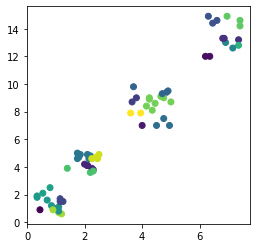

In [150]:
plt.figure(figsize=(4, 4))

# Incorrect number of clusters
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)
plt.show()

# **LVQ**

In [159]:
pip install -U sklearn-lvq[docs]

GLVQ:
not implemented!
classification accuracy: 0.06896551724137931


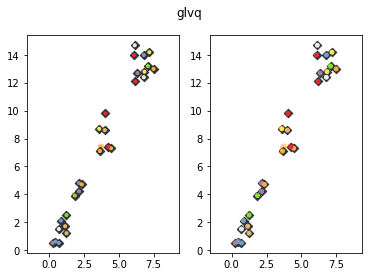

In [160]:
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/plot_rslvq.html
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/index.html
#https://mrnuggelz.github.io/sklearn-lvq/modules/generated/sklearn_lvq.GlvqModel.html#sklearn_lvq.GlvqModel
print('GLVQ:')
#nb_ppc = 100
#toy_data = np.append(
#    np.random.multivariate_normal([0, 0], np.eye(2) / 2, size=nb_ppc),
#    np.random.multivariate_normal([5, 0], np.eye(2) / 2, size=nb_ppc), axis=0)
#toy_label = np.append(np.zeros(nb_ppc), np.ones(nb_ppc), axis=0)

glvq = GlvqModel()
glvq.fit(X_train, labels)
plot2d(glvq, values, labels, 1, 'glvq')

print('classification accuracy:', glvq.score(values, labels))
plt.show()